##Respostas da 3º Avaliação de SD- 2025

Alunas: Vandirleya Barbosa da Costa e Viviane Barbosa Leal Dias


Q1. Utilizando o Algoritmo Genético ou a Evolução Diferenciada projete uma solução para retornar um conjunto de nós que representa o menor atraso de transmissão de um serviço a um cliente.

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import random
import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

In [ ]:
# Funções aleatórias para atribuição a nós
def generate_random_functions():
    return [f'func{i}' for i in range(1, 11)]

In [ ]:
# Função para criar um grafo com nós e enlaces
def create_graph(num_nodes, num_edges):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, function=random.choice(generate_random_functions()))

    for _ in range(num_edges):
        node1, node2 = random.sample(range(num_nodes), 2)
        delay = random.randint(1, 10)
        G.add_edge(node1, node2, delay=delay)

    return G

In [ ]:
# Função para criar um serviço com funções aleatórias
def create_service():
    num_funcs = random.randint(3, 10)
    service = random.sample(generate_random_functions(), num_funcs)
    return service

In [ ]:
# Função para criar requisições de clientes
def create_request(num_nodes, services):
    service = random.choice(services)
    origin, destination = random.sample(range(num_nodes), 2)
    return {'service': service, 'origin': origin, 'destination': destination}

In [ ]:
# Função para validar as requisições
def validate_request(request, G):
    service = request['service']
    origin = request['origin']
    destination = request['destination']

    if origin == destination:
        return False

    # Verifica se as funções estão em nós separados
    nodes_with_functions = {node: G.nodes[node]['function'] for node in G.nodes}
    nodes_used = set()

    for func in service:
        found = False
        for node, node_function in nodes_with_functions.items():
            if node_function == func and node not in nodes_used:
                nodes_used.add(node)
                found = True
                break
        if not found:
            return False
    return True

# Versão sequencial

In [ ]:
def find_min_delay_path_sequential(request, G):
    service = request['service']
    origin = request['origin']
    path = []
    total_delay = 0
    current_node = origin

    for func in service:
        for neighbor in G.neighbors(current_node):
            if G.nodes[neighbor]['function'] == func:
                path.append((current_node, neighbor))
                total_delay += G[current_node][neighbor]['delay']
                current_node = neighbor
                break

    return path, total_delay

# Versão paralela

In [ ]:
def find_min_delay_path_parallel(request, G):
    service = request['service']
    origin = request['origin']
    path = []
    total_delay = 0

    with ThreadPoolExecutor() as executor:
        current_node = origin
        futures = []

        for func in service:
            futures.append(executor.submit(search_for_func, current_node, func, G))

        for future in futures:
            result = future.result()
            if result[0] is not None:
                node, delay = result
                path.append((current_node, node))
                total_delay += delay
                current_node = node

    return path, total_delay

In [ ]:
def search_for_func(current_node, func, G):
    for neighbor in G.neighbors(current_node):
        if G.nodes[neighbor]['function'] == func:
            return neighbor, G[current_node][neighbor]['delay']
    return None, 1e6  # Penalidade alta

# Versão distribuída

In [ ]:
def find_min_delay_path_distributed(request, G):
    service = request['service']
    origin = request['origin']
    path = []
    total_delay = 0

    with multiprocessing.Pool() as pool:
        current_node = origin
        results = []

        for func in service:
            results.append(pool.apply_async(search_for_func, (current_node, func, G)))

        for result in results:
            node, delay = result.get()
            if node is not None:
                path.append((current_node, node))
                total_delay += delay
                current_node = node

    return path, total_delay

#Algoritmo Genético

In [ ]:
def genetic_algorithm(request, G, pop_size=50, generations=100):
    service = request['service']
    origin = request['origin']

    # Define o espaço de busca: nós do grafo
    nodes = list(G.nodes)

    # Criação do ambiente do DEAP
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_node", random.choice, nodes)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_node, n=len(service))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Avaliação de um caminho
    def evaluate(ind):
        total_delay = 0
        current_node = origin
        for func, next_node in zip(service, ind):
            if G.nodes[next_node]['function'] == func and G.has_edge(current_node, next_node):
                total_delay += G[current_node][next_node]['delay']
                current_node = next_node
            else:
                return 1e6,  # Penalidade alta para soluções inválidas
        return total_delay,

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Executa o Algoritmo Genético
    population = toolbox.population(n=pop_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=generations, verbose=False)

    # Retorna o melhor indivíduo
    best_ind = tools.selBest(population, k=1)[0]
    best_path = [(origin, best_ind[0])]
    for i in range(1, len(best_ind)):
        best_path.append((best_ind[i-1], best_ind[i]))
    return best_path, evaluate(best_ind)[0]

# Executar os testes

In [ ]:
def run_tests(num_tests, num_nodes, num_edges, services):
    results = {'sequential': [], 'parallel': [], 'distributed': []}
    errors = 0

    for _ in range(num_tests):
        G = create_graph(num_nodes, num_edges)
        requests = [create_request(num_nodes, services) for _ in range(10)]

        for request in requests:
            if not validate_request(request, G):
                errors += 1
            else:
                # Teste sequencial
                start = time.time()
                _, delay = find_min_delay_path_sequential(request, G)
                results['sequential'].append({'delay': delay, 'time': time.time() - start})

                # Teste paralelo
                start = time.time()
                _, delay = find_min_delay_path_parallel(request, G)
                results['parallel'].append({'delay': delay, 'time': time.time() - start})

                # Teste distribuído
                start = time.time()
                _, delay = find_min_delay_path_distributed(request, G)
                results['distributed'].append({'delay': delay, 'time': time.time() - start})

    print(f"Erros detectados: {errors}")
    return results

# Plotagem dos graficos

In [ ]:
def analyze_results(results):
    delay_metrics = {}
    time_metrics = {}

    for key in results:
        delays = [r['delay'] for r in results[key]]
        times = [r['time'] for r in results[key]]

        delay_metrics[key] = {
            "min": np.min(delays),
            "mean": np.mean(delays),
            "max": np.max(delays),
            "std": np.std(delays)
        }

        time_metrics[key] = {
            "min": np.min(times),
            "mean": np.mean(times),
            "max": np.max(times),
            "std": np.std(times)
        }

        print(f"Resultados para {key}:")
        print("  Delay - Min:", delay_metrics[key]["min"], "Mean:", delay_metrics[key]["mean"], "Max:", delay_metrics[key]["max"], "Std:", delay_metrics[key]["std"])
        print("  Tempo - Min:", np.min(times), "Mean:", np.mean(times), "Max:", np.max(times), "Std:", np.std(times))

    return delay_metrics, time_metrics

# Resultados

In [ ]:
results = run_tests(num_tests=30, num_nodes=10, num_edges=20, services=[create_service() for _ in range(10)])

delay_metrics, time_metrics = analyze_results(results)

Erros detectados: 247
Resultados para sequential:
  Delay - Min: 0 Mean: 8.90566037735849 Max: 29 Std: 6.874245484341979
  Tempo - Min: 1.3113021850585938e-05 Mean: 4.086854322901312e-05 Max: 7.295608520507812e-05 Std: 1.2978104580434268e-05
Resultados para parallel:
  Delay - Min: 0 Mean: 7.943396226415095 Max: 28 Std: 6.205338828386416
  Tempo - Min: 0.000774383544921875 Mean: 0.0010369138897589917 Max: 0.003468036651611328 Std: 0.000404451189572275
Resultados para distributed:
  Delay - Min: 0 Mean: 7.943396226415095 Max: 28 Std: 6.205338828386416
  Tempo - Min: 0.03769540786743164 Mean: 0.04248142692278016 Max: 0.056426048278808594 Std: 0.0036621995658884256


# Gráficos

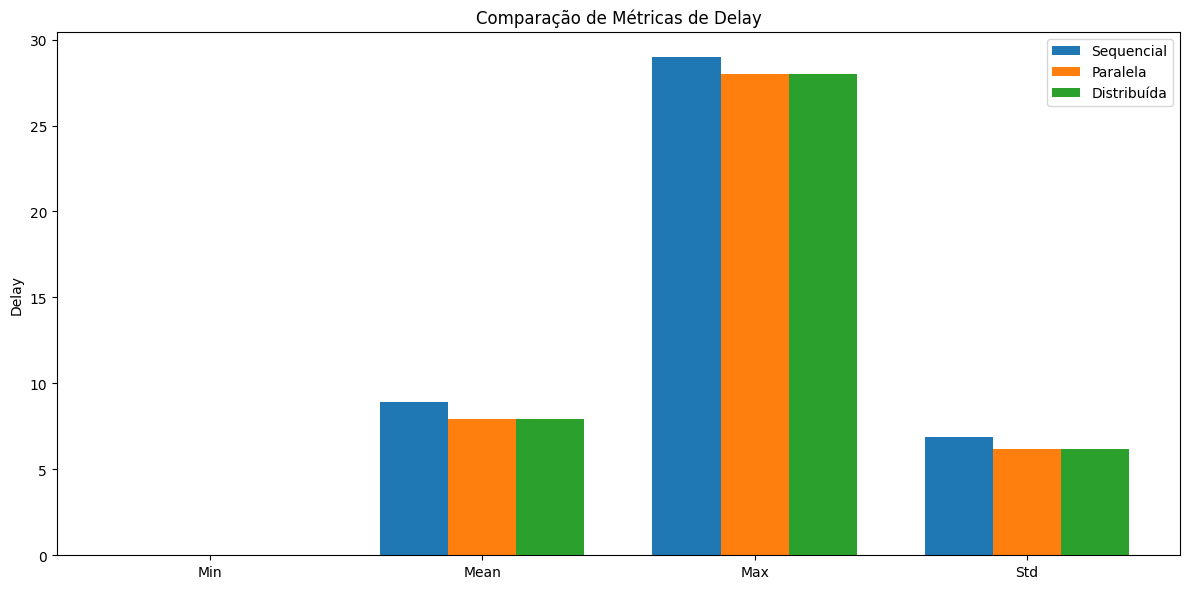

In [ ]:
labels = ["Min", "Mean", "Max", "Std"]
sequential_values = [delay_metrics["sequential"]["min"], delay_metrics["sequential"]["mean"], delay_metrics["sequential"]["max"], delay_metrics["sequential"]["std"]]
parallel_values = [delay_metrics["parallel"]["min"], delay_metrics["parallel"]["mean"], delay_metrics["parallel"]["max"], delay_metrics["parallel"]["std"]]
distributed_values = [delay_metrics["distributed"]["min"], delay_metrics["distributed"]["mean"], delay_metrics["distributed"]["max"], delay_metrics["distributed"]["std"]]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, sequential_values, width, label="Sequencial")
rects2 = ax.bar(x, parallel_values, width, label="Paralela")
rects3 = ax.bar(x + width, distributed_values, width, label="Distribuída")

ax.set_ylabel("Delay")
ax.set_title("Comparação de Métricas de Delay")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

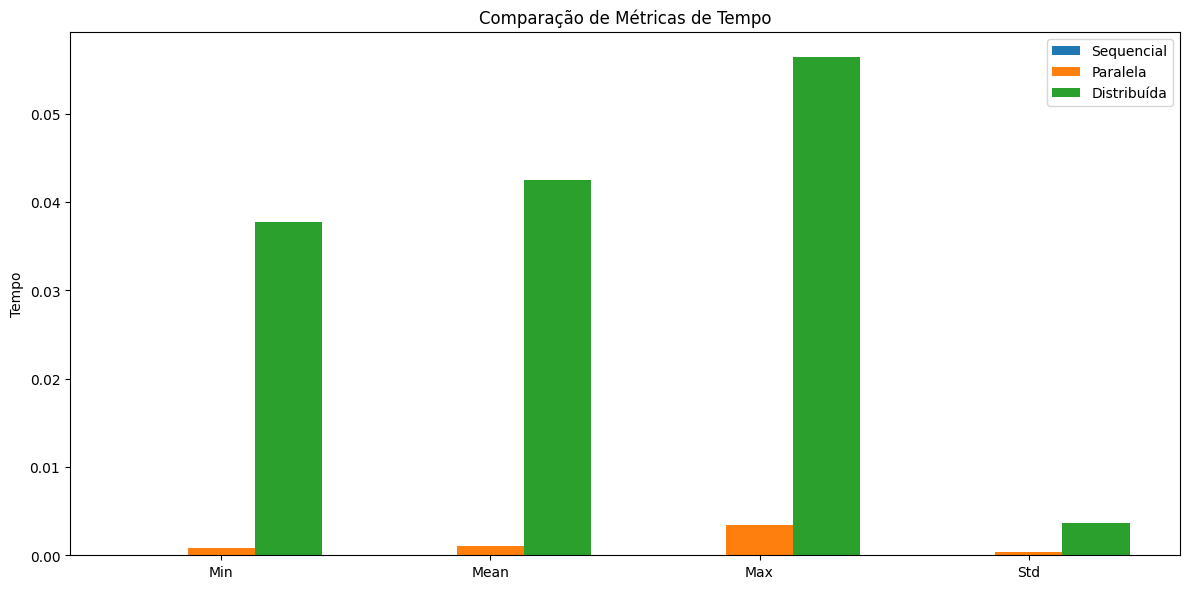

In [ ]:
labels = ["Min", "Mean", "Max", "Std"]

sequential_values = [time_metrics["sequential"]["min"], time_metrics["sequential"]["mean"], time_metrics["sequential"]["max"], time_metrics["sequential"]["std"]]
parallel_values = [time_metrics["parallel"]["min"], time_metrics["parallel"]["mean"], time_metrics["parallel"]["max"], time_metrics["parallel"]["std"]]
distributed_values = [time_metrics["distributed"]["min"], time_metrics["distributed"]["mean"], time_metrics["distributed"]["max"], time_metrics["distributed"]["std"]]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, sequential_values, width, label="Sequencial")
rects2 = ax.bar(x, parallel_values, width, label="Paralela")
rects3 = ax.bar(x + width, distributed_values, width, label="Distribuída")

ax.set_ylabel("Tempo")
ax.set_title("Comparação de Métricas de Tempo")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

#Perguntas

#1. Qual foi a abordagem mais rápida e por quê?



A abordagem sequencial foi a mais rápida em termos de tempo de execução por requisição. A versão sequencial não possui sobrecarga de comunicação ou gerenciamento de threads/processos, o que reduz significativamente o tempo necessário para processar cada requisição.

#2. Vantagens e desvantagens de cada abordagem

Sequencial

- Vantagens:
Simplicidade de implementação e menor sobrecarga de processamento.

- Desvantagens:
Escalabilidade limitada para problemas maiores ou mais complexos.
Não aproveita múltiplos núcleos da CPU.

Paralela

- Vantagens:
Divide o trabalho entre threads, reduzindo o tempo total para grandes quantidades de requisições.
Usa múltiplos núcleos da CPU, aumentando a eficiência em problemas com alta concorrência.

- Desvantagens:
Possui maior sobrecarga de gerenciamento de threads.
O desempenho pode ser limitado por contenção de recursos e overhead de sincronização.

Distribuída

- Vantagens:
Ideal para problemas de grande escala, distribuindo o trabalho entre processos ou máquinas.
Escalabilidade superior para aplicações com muitas requisições ou grafos muito complexos.

- Desvantagens:
Maior sobrecarga de comunicação e sincronização.
Dependente de configurações de infraestrutura (ex.: latência de rede).
Maior custo computacional devido ao gerenciamento distribuído.

# 3. O que você melhoraria na versão distribuída?

- Performance: Verificaria se cada nó processa uma quantidade similar de requisições, evitando que alguns fiquem sobrecarregados enquanto outros estão ociosos. Alem disso, ajustaria o tamanho das subpopulações para equilibrar o custo computacional da evolução local e a comunicação entre nós.


- Interoperabilidade: Partiria para a containerização, tentaria usar o Docker para encapsular o ambiente de execução, garantindo portabilidade e facilidade de implantação.

- Confiabilidade: Configuraria réplicas redundantes para cada processo crítico, o que permitiria a recuperação rápida em caso de falha de um nó.